### 一、导入依赖

In [1]:
from datetime import datetime, timedelta
import os
import json
import random
import logging
import warnings
import math
from typing import List, Set, Tuple

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, Normalize, ToTensor
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm
import torch.nn as nn
from torch import distributions
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import spacy
from rouge import Rouge

### 二、加载/构建词表

In [2]:
class OOVWarning(Warning):
    pass


class EndLabelNotFoundWarning(Warning):
    pass


class Vocabulary:
    def __init__(self, json_filepath):
        with open(json_filepath, 'rb') as fp:
            self._content: dict = json.load(fp)  # str -> int
        self.inv = {v: k for k, v in self._content.items()}  # int -> str

        self.pad: int = self._content['<pad>']  # int
        self.start: int = self._content['<start>']  # int
        self.end: int = self._content['<end>']  # int
        self.unk: int = self._content['<unk>']  # int
        self.spec_words: Set[int] = {self.pad, self.start, self.end, self.unk}  # 特殊字符
        self.size = len(self._content)
        self.nlp = spacy.load("en_core_web_sm")

    @staticmethod
    def build(raw_documents: List[str], save_path):
        """
        Vocabulary Factory
        :param raw_documents:
        :param save_path:
        :return:
        """
        content = {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3}
        nlp = spacy.load("en_core_web_sm")
        for raw_document in tqdm(raw_documents):
            for token in nlp(raw_document):
                if token.text.lower() not in content:
                    content[token.text.lower()] = len(content)
        with open(save_path, 'w') as fw:
            json.dump(content, fw)
        return Vocabulary(save_path)

    def __len__(self):
        return len(self._content)

    def __getitem__(self, word):
        if word in self._content:
            return self._content[word]
        else:
            warnings.warn(f'词表之外的词汇{word}，被编码为 <unk>', OOVWarning)
            return self.unk

    def get_word2vec(self, cache_path='word2vec.npy'):
        """获取词表的词向量嵌入, spacy提供的支持，固定提供96维词嵌入"""
        try:
            return np.load(cache_path)
        except FileNotFoundError:
            logging.log(0, 'building word2vec matrix...')
            word2vecs = []
            for idx, word in self.inv.items():
                word2vecs.append(
                    self.nlp(word)[0].tensor if idx not in self.spec_words else np.random.randn(96))  # nlp提供96维嵌入
            np.save(cache_path, np.array(word2vecs))
            return np.array(word2vecs)

    @staticmethod
    def post_process(string: str):
        s1 = string.replace(' .', '.').replace(' ,', ',').replace(' -', '-').replace('- ', '-')  # 标点间隔0
        s2 = s1[0].upper() + s1[1:]  # 开头大写
        return s2

    def encode(self, sentence, fixed_length=None) -> List[int]:
        """
        将文本编码为序列
        :param sentence:
        :param
        :return:
        """
        indices = [self.start] + [self[token.text.lower()] for token in self.nlp(sentence)] + [self.end]
        if fixed_length is not None:
            indices = (indices + [self.pad] * (fixed_length - len(indices)))[:fixed_length]
        return indices

    def decode(self, sequence: List[int]) -> str:
        """
        将序列解码为文本，跳过特殊字符，遇到终止符结束
        :param sequence:
        :return:
        """
        words = []
        for idx in sequence:
            if idx == self.end:
                break
            if idx not in self.inv:
                raise KeyError(f'索引{idx}超出了词表的范围，词表长度：{self.__len__()}')
            elif idx not in self.spec_words:  # 跳过特殊字符
                words.append(self.inv[idx])
        else:
            warnings.warn('没有在序列中发现终止符<end>', EndLabelNotFoundWarning)
        return self.post_process(' '.join(words))


In [4]:
root_dir = 'data/deepfashion-multimodal'

vocabulary = Vocabulary('vocab.json')

### 三、构建数据集

In [5]:
class ImageTextDataset(Dataset):
    def __init__(self, root_dir, vocabulary: Vocabulary, max_seq_len, transform=lambda x: x, train=True, split=True):
        """
        Args:
            root_dir (string): Root directory of the dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        label_path = os.path.join(root_dir, f'{"train" if train else "test"}_captions{"_split" if split else ""}.json')
        with open(label_path, 'rb') as fp:
            self.filenames, self.labels = zip(*json.load(fp)) if split else zip(*json.load(fp).items())

        self.root_dir = root_dir

        self.vocabulary = vocabulary
        self.max_seq_len = max_seq_len
        self.transform = transform

        self.image_cache = {}
        self.image_size = None

    def __len__(self):
        return len(self.filenames)

    def get_pair(self, idx):
        image_path = os.path.join(self.root_dir, 'images', self.filenames[idx])
        text_label = self.labels[idx]
        return image_path, text_label
    

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_path = os.path.join(self.root_dir, 'images', self.filenames[idx])
        if image_path not in self.image_cache:  # 如果图像不在缓存中
            image = self.transform(Image.open(image_path))
            # 估算图像大小
            if self.image_size is None:
                self.image_size = image.element_size() * image.nelement()  # 单位：字节
            # 检查是否超过60GB限制
            if len(self.image_cache) * self.image_size <= 16 * 1024**3:  # 60GB
                self.image_cache[image_path] = image  # 缓存图像
        else:
            image = self.image_cache[image_path]  # 从缓存中获取图像

        indices = vocabulary.encode(self.labels[idx], fixed_length=self.max_seq_len)
        seq = torch.LongTensor(np.array(indices))

        return image, seq

### 四、搭建模型

In [6]:
class ImageEncoder(nn.Module):
    def __init__(self, channels_in, channels_out):
        """
        CNN图像编码器，得到图像局部特征图
        :param channels_in: 输入图像通道数
        :param channels_out: 
        """
        super(ImageEncoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels_in, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, channels_out, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        return x



def generate_square_subsequent_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.bool)
    return mask


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """为序列注入位置编码"""
        x = x + self.pe[:x.size(0), :]
        return x


class AttentionDecoder(nn.Module):
    def __init__(self, vocab_size, text_embed_dim, feature_channels, hidden_size, num_layers, num_heads, 
                 pretrained_embeddings=None):
        super(AttentionDecoder, self).__init__()

        if pretrained_embeddings is not None:
            assert pretrained_embeddings.shape == (vocab_size, text_embed_dim), "预训练嵌入向量尺寸不匹配"
            # 使用预训练的嵌入向量
            self.text_embed = nn.Embedding.from_pretrained(torch.FloatTensor(pretrained_embeddings), freeze=False)
        else:
            # 随机初始化嵌入向量
            self.text_embed = nn.Embedding(vocab_size, text_embed_dim)
        
        self.image_feature_projection = nn.Conv2d(in_channels=feature_channels, 
                                                  out_channels=hidden_size, 
                                                  kernel_size=1)
        
        self.text_feature_projection = nn.Conv1d(in_channels=text_embed_dim, 
                                                 out_channels=hidden_size, 
                                                 kernel_size=1)
        
        self.positional_encoder = PositionalEncoding(hidden_size, max_len=max_seq_length)
        
        self.self_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        self.self_attention2 = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        self.self_attention3 = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        
        self.cross_attention = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=num_heads)
        
        # 定义多个 Transformer 解码器层
        self.decoder_layers = nn.ModuleList([nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
                                             for _ in range(num_layers)])
        self.transformer_decoder = nn.TransformerDecoder(self.decoder_layers, num_layers)
        
        # self.decoder_layers = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads)
        # self.transformer_decoder = nn.TransformerDecoder(self.decoder_layers, num_layers)
        self.fc_out = nn.Linear(hidden_size, vocab_size)
        

    
    def forward(self, text_seq, image_features):
        # text_seq: (batch_size, seq_len)
        # image_features: (batch_size, feature_channels, feature_height, feature_width)
        
        text_embeds = self.text_embed(text_seq)  # (batch_size, seq_len, text_embed_dim)
        text_embeds = text_embeds.permute(0, 2, 1)  # (batch_size, text_embed_dim, seq_len)
        text_embeds = self.text_feature_projection(text_embeds)  # (batch_size, hidden_size, seq_len)
        text_embeds = text_embeds.permute(2, 0, 1)  # (seq_len, batch_size, hidden_size)
        
        text_embeds = self.positional_encoder(text_embeds)
        
        # 展平图像特征并通过线性层投影
        batch_size, C, H, W = image_features.size()
        image_features = self.image_feature_projection(image_features)  # (B, hidden_size, H, W)
        image_features = image_features.permute(2, 3, 0, 1).contiguous()  # (H, W, batch_size, hidden_size)
        image_features = image_features.view(H * W, batch_size, -1)  # (H*W, batch_size, hidden_size)
        
        # 生成注意力掩码
        seq_len = text_seq.size(1)
        attn_mask = generate_square_subsequent_mask(seq_len).to(text_seq.device)
        
        # 使用自注意力（应用掩码）
        text_embeds, _ = self.self_attention(text_embeds, text_embeds, text_embeds, attn_mask=attn_mask)
        text_embeds, _ = self.self_attention2(text_embeds, text_embeds, text_embeds, attn_mask=attn_mask)
        text_embeds, _ = self.self_attention3(text_embeds, text_embeds, text_embeds, attn_mask=attn_mask)  # (seq_len, batch_size, hidden_size)

        # 使用跨模态注意力
        text_embeds, image_attention_weights = self.cross_attention(text_embeds, image_features, image_features)# (seq_len, batch_size, hidden_size)

        # 使用 Transformer 解码器
        output = self.transformer_decoder(text_embeds, image_features)  # (seq_len, batch_size, hidden_size)
        output = output.permute(1, 0, 2)  # (batch_size, seq_len, hidden_size)

        # 应用输出层
        output = self.fc_out(output)  # (batch_size, seq_len, vocab_size)
        return output, image_attention_weights


class ImageTextAttentionModel(nn.Module):
    def __init__(self, vocab_size, channels, feature_channels, text_embed_dim, hidden_size, num_layers, num_heads, 
                 pretrained_embeddings=None):
        super(ImageTextAttentionModel, self).__init__()
        self.encoder = ImageEncoder(channels, feature_channels)
        self.decoder = AttentionDecoder(vocab_size, text_embed_dim, feature_channels, hidden_size, num_layers, num_heads, 
                                        pretrained_embeddings=pretrained_embeddings)

    def forward(self, images, seq):
        image_features = self.encoder(images)  # 提取图像特征图
        output, attention_weights = self.decoder(seq, image_features)
        return output, attention_weights
    
    def predict(self, image: Image.Image, seq: List[int], device) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        
        :param image: 
        :param seq: 
        :param device: 
        :return: probs
        """
        assert isinstance(seq, list)
        image = transform(image).unsqueeze(0).to(device)  # -> (1, channel, img_size, img_size)
        seq = torch.LongTensor(seq).unsqueeze(0).to(device)
        with torch.no_grad():
            out, attention_weights = self.forward(image, seq)
            probs = F.softmax(out[:, -1, :], dim=-1)  # 应用 softmax 获取概率分布
        return probs, attention_weights  # (vocab_size, )

In [11]:
# 训练配置
epochs = 200
image_size = (256, 256)
lr = 5e-4
batch_size = 32
image_embed_dim = 64
text_embed_dim = 96
feature_channels = 128
hidden_size = 64
num_layers = 4
num_heads = 4
model_name = 'transformer'

channels = 3
max_seq_length = 128  # 序列最大长度

# 可用的训练设备
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

### 五、加载模型权重

In [12]:
os.makedirs('history', exist_ok=True)
os.makedirs('models', exist_ok=True)
history_path = f'history/history_{model_name}.npy'
model_path = f'models/model_{model_name}.pth'


# 模型初始化
model = ImageTextAttentionModel(len(vocabulary), channels, feature_channels, text_embed_dim, hidden_size, num_layers, num_heads,
                       pretrained_embeddings=vocabulary.get_word2vec()).to(device)

running_losses, val_losses, val_accuracies = [], [], []
try:
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        running_losses, val_losses, val_accuracies = np.load(history_path).tolist() if os.path.exists(history_path) else ([], [], [])
except Exception as e:
    print('rebuilding model')
    

transform = Compose([
    Resize(image_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

rebuilding model


### 六、加载数据集

In [9]:
# 加载数据集
train_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length, transform=transform,
                             train=True, split=False)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length, transform=transform,
                           train=False, split=False)
val_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

### 七、开始训练

In [13]:
# 损失函数和优化器
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter('runs/fashion_description')

# 训练循环
p_bar = tqdm(range(epochs))
model = model.to(device)
save_interval = timedelta(minutes=2)

for epoch in p_bar:
    running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_loss = 0.
    meteor_acc = 0.

    model.train()
    last_save_time = datetime.now()
    for batch_idx, (image, seq) in enumerate(train_loader):
        image = image.to(device)  # 图像数据
        seq = seq.to(device)  # 序列数据

        input_seq = seq[:, :-1]  # (batch, seq_len - 1)
        target_seq = seq[:, 1:]  # (batch, seq_len - 1)

        # 开始训练
        optimizer.zero_grad()
        prediction, _ = model(image, input_seq)  # (batch, seq_len - 1, vocabulary_size)
        loss = criterion(prediction.view(-1, vocabulary.size), target_seq.contiguous().view(-1))
        loss.backward()
        optimizer.step()

        time_since_last_save = datetime.now() - last_save_time

        if time_since_last_save > save_interval:  # 每隔两分钟自动保存
            last_save_time = datetime.now()
            torch.save(model.state_dict(), model_path)

        # 记录结果
        running_loss += loss.item()
        p_bar.set_postfix(progress=f'{(batch_idx + 1)} / {len(train_loader)}',
                          loss=f'{running_loss / (batch_idx + 1):.4f}',
                          val_acc=f'{val_accuracies[-1] if len(val_accuracies) else 0.0:.4f}%',
                          val_loss=f'{val_losses[-1] if len(val_losses) else 0.0:.4f}',
                          save_count_down=(save_interval - time_since_last_save).total_seconds())
        writer.add_scalar('Loss/train', running_loss / (batch_idx + 1), epoch * len(train_loader) + batch_idx)

    model.eval()
    for batch_idx, (image, seq) in enumerate(val_loader):
        with torch.no_grad():
            seq = seq.to(device)
            image = image.to(device)

            input_seq = seq[:, :-1]  # (batch, seq_len - 1)
            target_seq = seq[:, 1:]  # (batch, seq_len - 1)

            output, _ = model(image, input_seq)  # (batch, seq_len - 1, voc_size)

            y_pred = output.reshape(-1, vocabulary.size)  # (batch * (seq_len - 1), voc_size)

            y_gt = target_seq.flatten()  # (batch * (seq_len - 1), )
            mask = ~torch.bitwise_or(y_gt == vocabulary.end, y_gt == vocabulary.pad)  # 掩码掉终止符和填充符

            loss = criterion(y_pred, y_gt)  # 计算损失
            rest = (y_pred.max(dim=1)[1] == y_gt)[mask]

            all_valid_cnt = mask.sum().item()
            true_valid_cnt = rest.sum().item()
            val_correct += true_valid_cnt  # 在非特殊字符上计算准确率
            val_total += all_valid_cnt
            val_loss += loss.item()

        p_bar.set_postfix(progress=f'{(batch_idx + 1) / len(train_loader) * 100:.3f}%',
                          loss=f'{running_loss / len(train_loader):.4f}',
                          val_acc=f'{val_correct / (val_total + 0.0001) * 100:.4f}%',
                          val_loss=f'{val_loss / (batch_idx + 1):.4f}',
                          mask_ratio=f'{len(rest)} / {len(y_gt)}')
        writer.add_scalar('Loss/val', val_loss / (batch_idx + 1), epoch * len(val_loader) + batch_idx)

    writer.add_scalar('Accuracy/val', val_correct / val_total * 100)
    running_losses.append(running_loss / len(train_loader))
    torch.save(model.state_dict(), model_path)
    val_accuracy = val_correct / val_total * 100
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss / len(val_loader))
    np.save(history_path, np.array([running_losses, val_losses, val_accuracies]))

 26%|██▋       | 53/200 [2:06:56<5:52:04, 143.70s/it, loss=0.0436, progress=16 / 318, save_count_down=116, val_acc=97.5334%, val_loss=0.0294]  


KeyboardInterrupt: 

In [14]:
def visualize_attention(original_image, attention_weights):
    # 将注意力权重重塑为原始图像的尺寸
    # 注意：这里需要根据图像特征图的尺寸和原始图像尺寸进行调整
    attention_map = attention_weights.view(original_image.size(1), original_image.size(2))

    # 可视化
    plt.imshow(original_image)
    plt.imshow(attention_map, cmap='jet', alpha=0.6)  # 可调整透明度
    plt.show()
    d
def predict_sequence(image, model, vocabulary: Vocabulary, start_seq='', max_seq_len=25, device='cpu'):
    model = model.to(device)
    
    # 初始化序列
    seq = vocabulary.encode(start_seq)[:-1]  # 去掉末尾的<end>
    model.eval()
    for _ in range(max_seq_len):
        probs, attention_weights = model.predict(image, seq, device)  # (vocab_size)
        # next_word_idx = probs.max(dim=1)[1].item()
        next_word_idx = distributions.Categorical(probs).sample().item()  # 采样
        seq.append(next_word_idx)
        # visualize_attention(image, attention_weights)
        if next_word_idx == vocabulary.end:
            break
        
    # 将索引转换为文本
    text = vocabulary.decode(seq)
    return text


def generate_description(model, image, vocab, device, max_length=50):
    image = transform(image).unsqueeze(0).to(device)  # -> (1, channel, img_size, img_size)

    # 初始化序列，开始标记
    seq = [vocab.start]
    # 将图像和文本序列放入设备（例如 GPU）
    image = image.to(device)
    seq = torch.tensor(seq, dtype=torch.long, device=device).unsqueeze(0)

    # 生成描述
    for _ in range(max_length):
        # 生成输出和注意力权重
        with torch.no_grad():
            output, _ = model(image, seq)
        
        # 从输出中获取最后一个词的索引
        predicted = output.argmax(2)[:, -1]
        seq = torch.cat((seq, predicted.unsqueeze(1)), dim=1)

        # 检查是否达到了终止符<end>
        if predicted.item() == vocab.end:
            break

    # 将序列转换为单词列表'
    seq = seq.squeeze(0).cpu().numpy().tolist()
    text = vocab.decode(seq)

    return text

In [15]:
full_val_set = ImageTextDataset(root_dir=root_dir, vocabulary=vocabulary, max_seq_len=max_seq_length,
                                transform=transform, train=True, split=False)

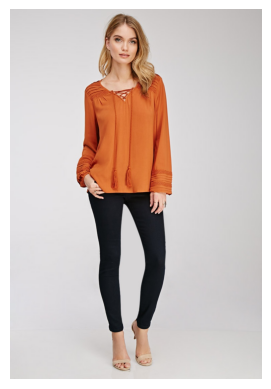

result:  Lady the her lady of the t the t the t t the t the the t the the the t the t the t top the t the t-shirt wears wearing wears neckline shirt shirt shirt lady-shirt is wears of of of wears of the t the length top has of of is of lady wears of-point lady wears of the female has of of lady on fabric the lady wears of of is of the lady on length the female lady female lady lady lady lady lady her lady of a lady the lady the lady lady lady has of is of is. the lady wears three lady has the lady 

answer: Her shirt has long sleeves, cotton fabric and graphic patterns. It has a v-shape neckline. This lady wears a long trousers. The trousers are with denim fabric and solid color patterns. There is a ring on her finger. There is an accessory on her wrist. 

rouge_l score:  0.3272727224727273


/tmp/ipykernel_3157/1976187465.py:97: EndLabelNotFoundWarning: 没有在序列中发现终止符<end>
  warnings.warn('没有在序列中发现终止符<end>', EndLabelNotFoundWarning)


In [25]:
i = random.choice(range(len(full_val_set)))
image_path, description = full_val_set.get_pair(i)
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # 可选：关闭坐标轴
plt.show()

predicted_sequence = generate_description(model, image, vocabulary, device, max_length=128)

# predicted_sequence = predict_sequence(image, model, vocabulary, start_seq='', device=device, max_seq_len=max_seq_length)
print('result: ', predicted_sequence, '\n')
print(f'answer:', description, '\n')
print('rouge_l score: ', calculate_rouge_l(predicted_sequence, description))